In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sc
import random
from datetime import datetime
MAX_REQUESTS = 1e4
print("imported")
import pandas as pd

imported


In [2]:
from queue import Queue
from threading import Thread
import time


def compute(lambda_):
    items = []
    def treat_job(q):
        while True:
            obj = q.get()
            job, s, (t11, t12), (t21,t22) = obj
        
            if job == 1:
                t11 = (datetime.utcnow()-start).total_seconds()*1000
                sleep_time = random.lognormvariate(1.5, 0.6)/1000
                time.sleep(sleep_time)
                t12 = (datetime.utcnow()-start).total_seconds()*1000
                q.put((2, s , (t11, t12), (t21, t22)))

            if job == 2:
                t21 = (datetime.utcnow()-start).total_seconds()*1000
                sleep_time = random.uniform(0.6,1)/1000
                time.sleep(sleep_time)
                t22 = (datetime.utcnow()-start).total_seconds()*1000
                items.append([s , t11, t12, t21, t22])

            q.task_done()

    q = Queue(maxsize=0) 

    worker = Thread(target=treat_job, args=(q,))
    worker.setDaemon(True)
    worker.start()
    start = datetime.utcnow()

    for _ in range(10**4):
        q.put((1, (datetime.utcnow()-start).total_seconds()*1000, (0, 0), (0,0)))
        time.sleep(random.expovariate(lambda_))
    print("Done putting into queue!")
    q.join()
    print("Queue done joining")
    return items

In [3]:
items = compute(80)

Done putting into queue!
Queue done joining


In [4]:
df = pd.DataFrame(items, columns = ['Start', 'T11', 'T12', 'T21', 'T22'])

In [5]:
df.head()

,Start,T11,T12,T21,T22
0,0.006,0.082,3.079,8.058,9.258
1,3.032,3.109,7.953,9.340,10.495
2,19.438,19.530,29.913,43.618,44.631
3,20.475,29.970,43.542,44.686,45.551
4,49.175,49.242,58.010,58.108,58.946


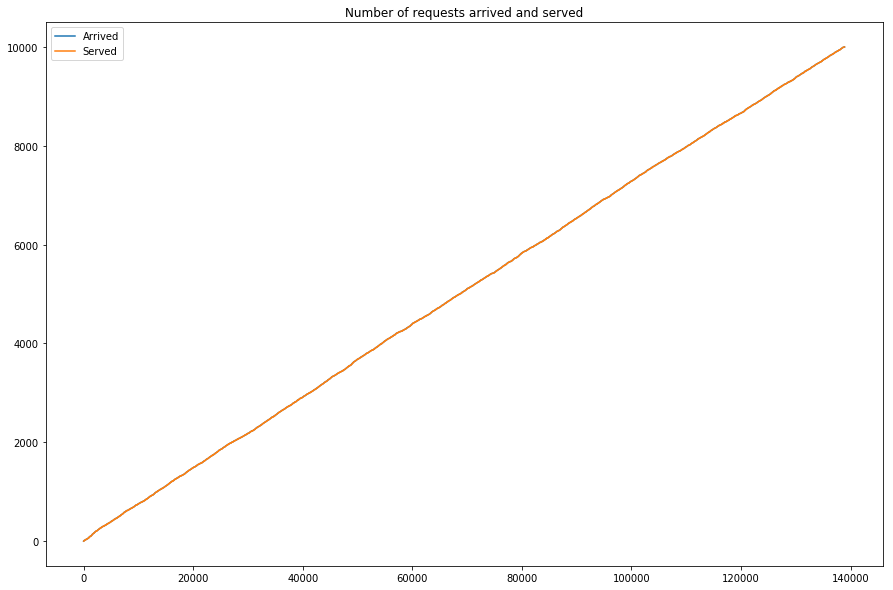

In [6]:
plt.figure(figsize=(15,10))
plt.plot(df['Start'], range(10**4), label="Arrived")
plt.step(df['T22'], range(10**4),label="Served")
plt.title("Number of requests arrived and served")
plt.legend()
plt.show()

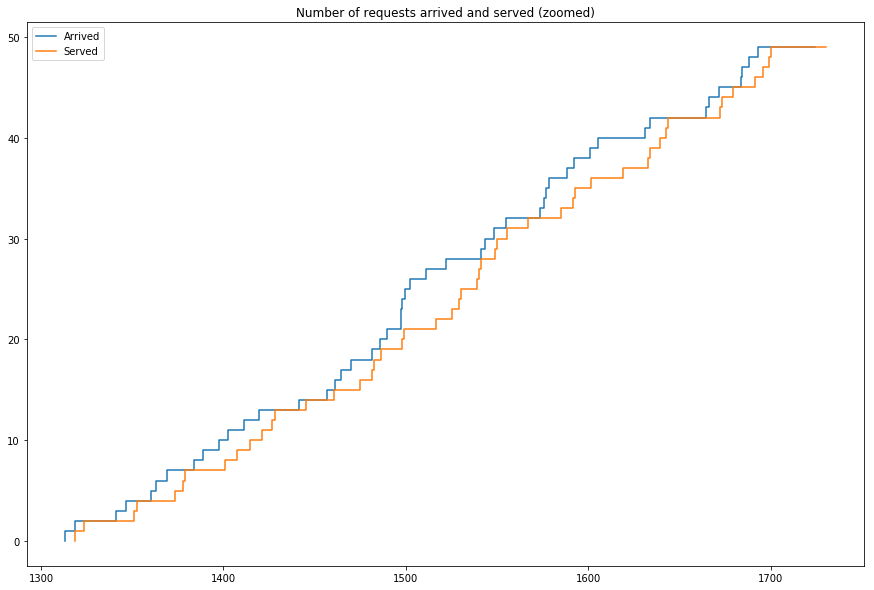

In [7]:
plt.figure(figsize=(15,10))
plt.step(df['Start'][100:150], range(50), label="Arrived")
plt.step(df['T22'][100:150], range(50), label="Served")
plt.title("Number of requests arrived and served (zoomed)")
plt.legend()
plt.show()

In [8]:
interesting_times = np.sort(np.concatenate((df['Start'].values, df['T12'].values)))
type1_in_queue = []
type2_in_queue = []
for t in interesting_times:
    type_ones = df[((df['Start'] - t) < 0) & ((df['T12'] - t > 0))]
    type_twos = df[((df['T12'] - t) < 0) & ((df['T22'] - t > 0))]
    type1_in_queue.append(len(type_ones))
    type2_in_queue.append(len(type_twos))

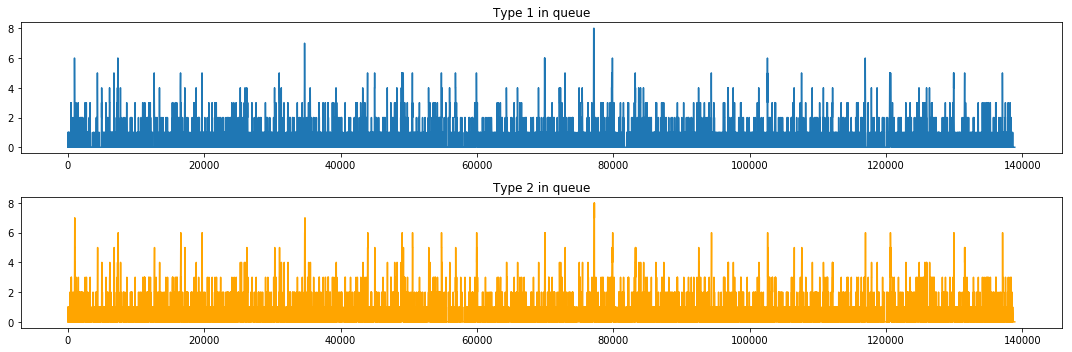

In [9]:
fig = plt.figure(figsize=(15,5))
fig.add_subplot(2,1,1)
plt.plot(interesting_times, type1_in_queue, c="C0")
plt.title("Type 1 in queue")
fig.add_subplot(2,1,2)
plt.plot(interesting_times, type2_in_queue, c="orange");
plt.title("Type 2 in queue")
plt.tight_layout()

### average response time (event average)

In [10]:
df['T2-Serv'] = df['T22']-df['T12']
df['T1-Serv'] = df['T12']-df['Start']

In [11]:
print("Average for type 1: {:.5f} ms".format(df['T1-Serv'].mean()))
print("Average for type 2: {:.5f} ms".format(df['T2-Serv'].mean()))

Average for type 1: 10.64806 ms
Average for type 2: 6.57476 ms


<Container object of 2 artists>

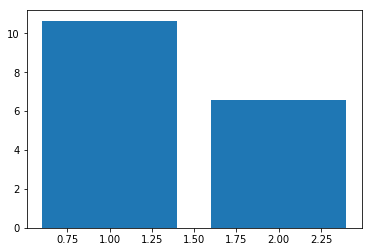

In [12]:
plt.bar([1,2],[df['T1-Serv'].mean(), df['T2-Serv'].mean()])

### Average number of jobs served per second

In [13]:
served = []
for sample_start_time in (df.values.max()-1000)*np.random.sample(50):
    served.append(df[(df['T21'] > sample_start_time) & (df['T22'] < sample_start_time+1000)].count()['Start'])
print(np.mean(served))

73.04


In [14]:
served = []
for sample_start_time in (df.values.max()-1000)*np.random.sample(50):
    served.append(df[(df['T11'] > sample_start_time) & (df['T12'] < sample_start_time+1000)].count()['Start'])
print(np.mean(served))

72.9


# 2

In [15]:
lambdas = np.arange(25, 250, 25)
queues = []

In [16]:
items = []
#for l in lambdas: 
#    it = compute(l)
#    items.append(it)

In [17]:
#for i in range(len(items)): 
#    df = pd.DataFrame(items[i], columns = ['Start', 'T11', 'T12', 'T21', 'T22'])
#    df.to_csv("lambda_"+str(25*(i+1)), index=False)

In [18]:
def plot_and_save_jobs(df ,name):
    interesting_times = np.sort(np.concatenate((df['Start'].values, df['T12'].values)))
    type1_in_queue = []
    type2_in_queue = []
    for t in interesting_times:
        type_ones = df[((df['Start'] - t) < 0) & ((df['T12'] - t > 0))]
        type_twos = df[((df['T12'] - t) < 0) & ((df['T22'] - t > 0))]
        type1_in_queue.append(len(type_ones))
        type2_in_queue.append(len(type_twos))
    fig = plt.figure(figsize=(15,5))
    fig.add_subplot(2,1,1)
    plt.plot(interesting_times, type1_in_queue, c="C0")
    plt.title("Type 1 in queue")
    fig.add_subplot(2,1,2)
    plt.plot(interesting_times, type2_in_queue, c="orange");
    plt.title("Type 2 in queue")
    plt.tight_layout()
    plt.savefig(name)
    plt.show()

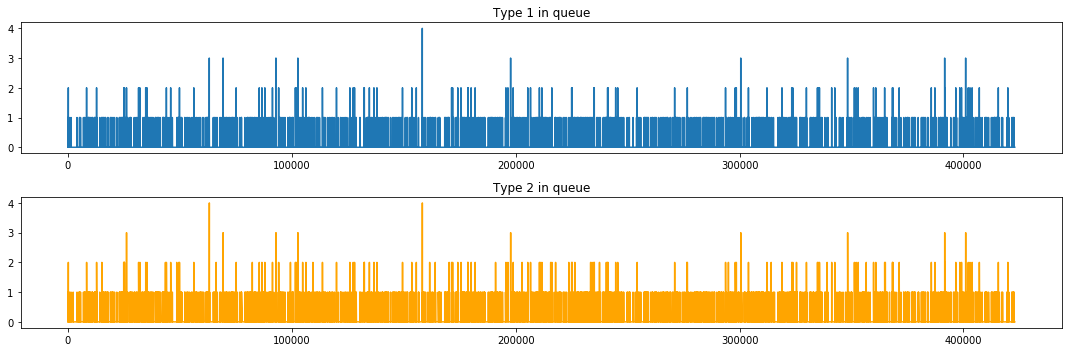

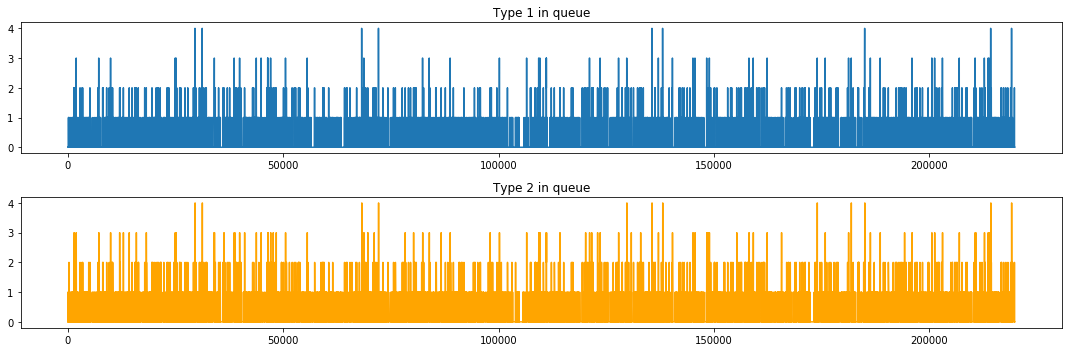

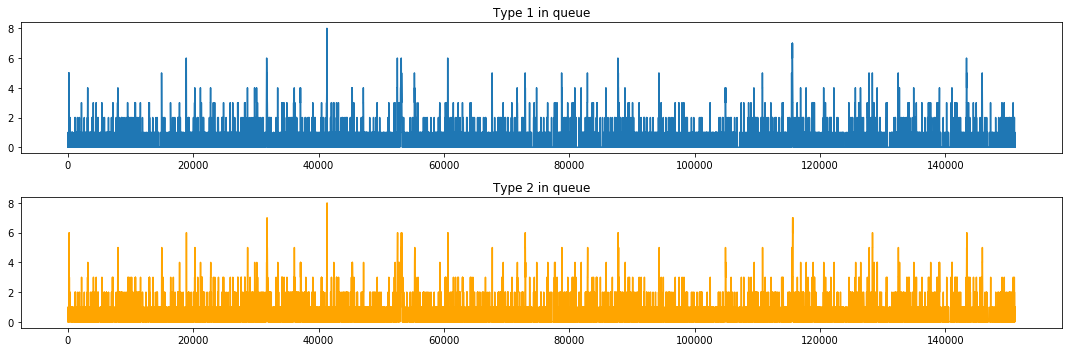

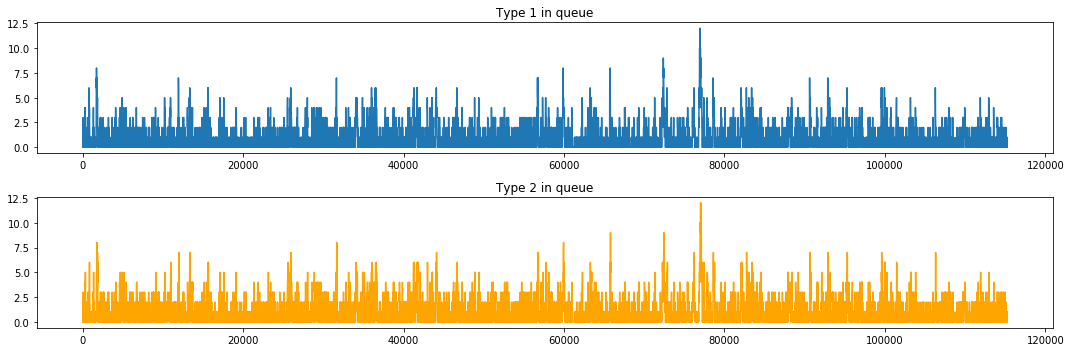

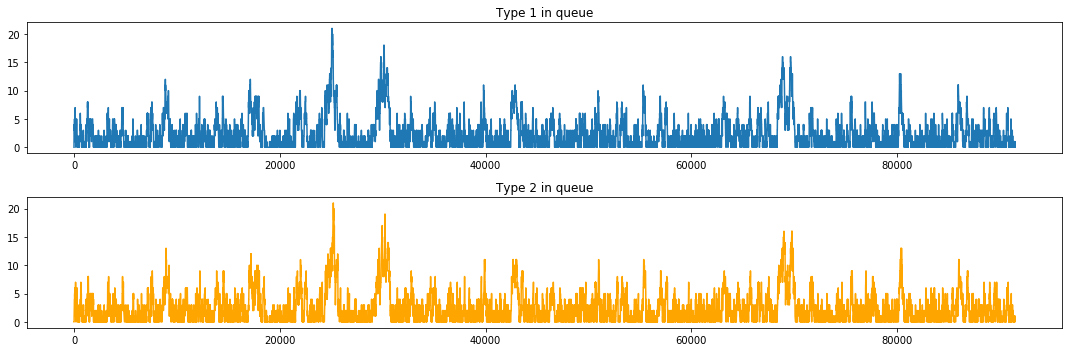

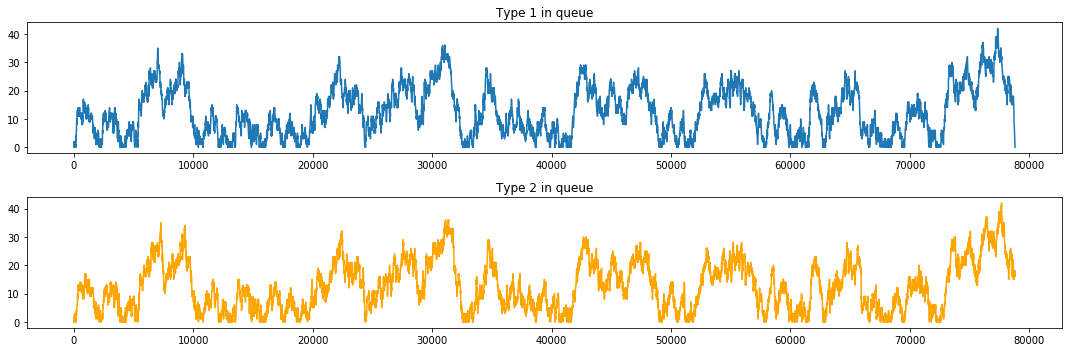

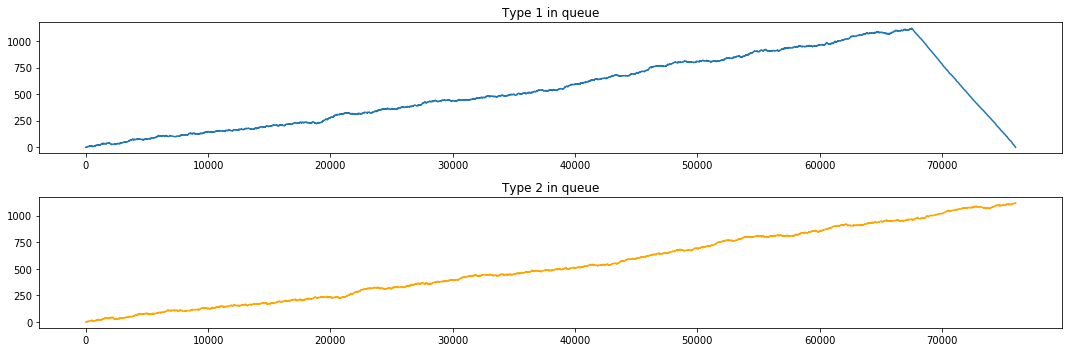

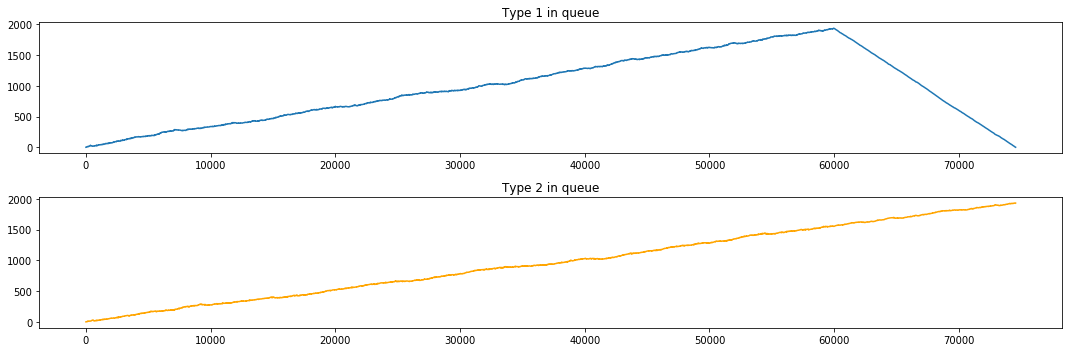

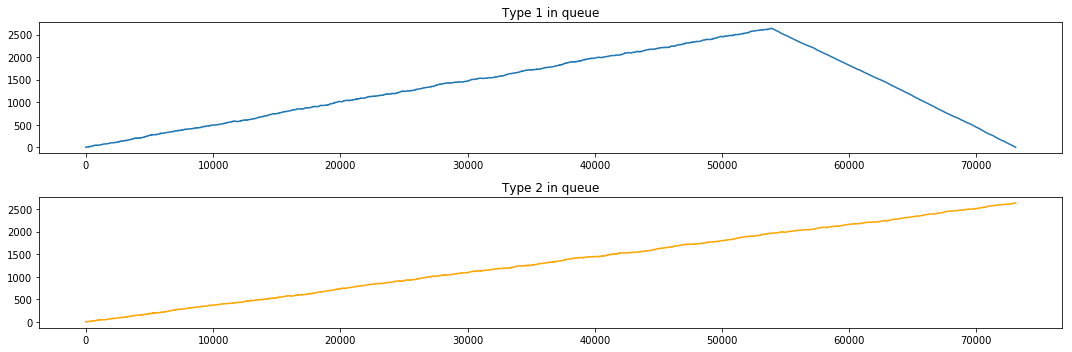

In [19]:
for l in lambdas:
    df = pd.read_csv("data/lambda_"+str(l))
    plot_and_save_jobs(df, "fig/jobs_lambda_"+str(l))

#### For which values of λ is the system stationary? 
The graphs show a stationary regime for lambda in the range (25, 150).

The system is stationary when the mean arrival time between 2 arrivals in the queue does not recede the sum of the mean of the log normal (1.5, 0.6) and the uniform distribution (0.6, 1).

As seen below, this is around 6.166 ms.

In [20]:
m = np.exp(1.5+(0.6**2)/2) + 0.8
print("Sum of mean of log-normal(1.5, 0.6) and normal(0.6, 1) = ", m, "ms")

Sum of mean of log-normal(1.5, 0.6) and normal(0.6, 1) =  6.165555971121974 ms


After looping through the values, we see that the max lambda for which there is a stationary regime is 162, after that the queue is saturated and the walk to infinity begins.

In [21]:
print("lambda = 162: ",1000/162, "requests/s, lambda = 163:" , 1000/163, "requests/s")

lambda = 162:  6.172839506172839 requests/s, lambda = 163: 6.134969325153374 requests/s


#### What happens on the plots when the system is not stationary ?
The system becomes unstable once the input rate is larger than the service capacity.

The buffer occupancy grows unbounded and the mean queue length increases.
There is a walk to infinity.

# 3

# 4

Little's Law: 
$\lambda\overline{R}=\overline{N}$, where $\lambda$ is the number of customer's arriving per second, $\overline{R}$ is the average time a customer spends in the system and $\overline{N}$ is the average number of customers observed in the system.

In [4]:
# |n - lambda* r| = 0

In [5]:
#with transient removal

In [6]:
#without transient removal

# 5

A new request arriving in the system is of type 1 with probability $1 - \epsilon$ and of type 2 with probability $\epsilon$ and we want to assume that $\epsilon$ is zero or almost zero.

First experiment: 10 random requests, all of type 1. 

The confidence interval for p when we observe z=0 successes is $\lbrack0, p_0(n)\rbrack$, with $p_0(n)=1-(\frac{1-\gamma}{2})^{\frac{1}{n}}$.

For $\gamma=0.95$ and $n=10$, we have:
$p_0(10)=1-(\frac{1-0.95}{2})^{\frac{1}{10}}=0.308$


Confidence interval for $\epsilon$: $\lbrack0, 0.308\rbrack$

Confidence interval for the stability region of the system: 

Second experiment: 
In order to assure that $\epsilon < 1\%$ with a $95\%$ confidence, assuming that a sample is always a type 1 request, we want $p_0(n) < 0.01$. 

$1-(\frac{1-0.95}{2})^{\frac{1}{n}} < 0.01$

$(0.025)^{\frac{1}{n}} > 0.99$

$\log{0.025^{\frac{1}{n}}} > \log{0.99}$

$\frac{\log0.025}{n} > \log{0.99}$

$\frac{-3.68888}{n}>-0.0100503$

$ n > 367.04$

We need to pick 368 samples in order to assure  $\epsilon < 1\%$ with  $95\%$ confidence.

In [15]:
import math

In [14]:
1-math.pow(0.025, 0.1)

0.30849710781876083

In [24]:
math.log(0.025)/math.log(0.99)

367.0404161497511